In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
mnist = keras.datasets.mnist

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


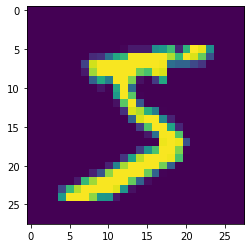

In [4]:
plt.imshow(x_train[0])

In [5]:
x_train = x_train/255.0

In [6]:
batch_size = 256
buffer_size = 60000
train_df = tf.data.Dataset.from_tensor_slices(x_train.reshape(x_train.shape[0], 784)).shuffle(buffer_size).batch(batch_size)

In [7]:
class Generator(keras.Model):
    def __init__(self, noise_size = 100):
        super().__init__(name='generator')
        self.input_layer = keras.layers.Dense(units = noise_size)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 256)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        self.output_layer = keras.layers.Dense(units = 784, activation = 'tanh')
        
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_3(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        return self.output_layer(x)
    
    def generate_noise(self, batch_size, noise_size):
        return np.random.uniform(-1, 1, size = (batch_size, noise_size))

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def generator_objective(x):
    return cross_entropy(tf.ones_like(x), x)

In [10]:
generator = Generator()

In [11]:
fake_img = generator(np.random.uniform(-1,1, size=(1,100)))
fake_img = tf.reshape(fake_img, shape=(28,28))

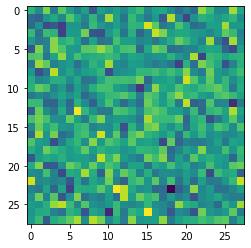

In [12]:
plt.imshow(fake_img)

In [13]:
class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name='discriminator')
        self.input_layer = keras.layers.Dense(units = 784)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 128)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        self.logits = keras.layers.Dense(units = 1)
        
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_3(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        return self.logits(x)

In [14]:
discriminator = Discriminator()

In [15]:
def discriminator_objective(d_x, g_z, factor = 0.9):
    #d_x - real output
    #g_z - fake output
    real_loss = cross_entropy(tf.ones_like(d_x) * factor, d_x)
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
gen_optimizer = keras.optimizers.RMSprop()
dis_optimizer = keras.optimizers.RMSprop()

In [17]:
@tf.function
def train_step(gen, dis, images, k=1, batch_size=32):
    for i in range(k):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            noise = gen.generate_noise(batch_size, 100)
            g_z = gen(noise)
            dx_true = dis(images)
            dx_fake = dis(g_z)
            
            dis_loss = discriminator_objective(dx_true, dx_fake)
            grad_dis = dis_tape.gradient(dis_loss, dis.trainable_variables)
            dis_optimizer.apply_gradients(zip(grad_dis, dis.trainable_variables))
            
            gen_loss = generator_objective(dx_fake)
            grad_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
            gen_optimizer.apply_gradients(zip(grad_gen, gen.trainable_variables))

In [18]:
import os
os.makedirs('output_dir')

In [19]:
some_data = np.random.uniform(-1,1,size=(1,100))
def training(data, epochs):
    for epoch in range(epochs):
        for batch in data:
            train_step(generator, discriminator, batch, batch_size=batch_size)
            
        if epoch % 10 == 0:
            fake_img = tf.reshape(generator(some_data),shape = (28,28))
            print("{} epochs completed".format(epoch))
            plt.imsave("output_dir/{}.png".format(epoch), fake_img)

In [20]:
training(train_df, 100)

0 epochs completed
10 epochs completed
20 epochs completed
30 epochs completed
40 epochs completed
50 epochs completed
60 epochs completed
70 epochs completed
80 epochs completed
90 epochs completed
